<a href="https://colab.research.google.com/github/NissuGeorge/testing/blob/master/GMM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

In [47]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((x_train.shape[0], -1)) / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)) / 255.0

pca = PCA(n_components=50) # k is the number of desired components
x_train_pca = pca.fit_transform(x_train)
#X=(x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)

x_test_pca = pca.fit_transform(x_test)


def initialize_parameters(X, n_clusters):

  n_samples, n_features = X.shape

  # Initialize means using kmeans
  kmeans = KMeans(n_clusters)
  kmeans.fit(X)
  means = kmeans.cluster_centers_
  assignments = kmeans.labels_
  
  # calculate variance for each cluster
  variances = np.zeros(n_clusters)
  for k in range(n_clusters):
      cluster_points = X[assignments == k]
      distances = np.sum((cluster_points - means[k])**2, axis=1)
      variances[k] = np.mean(distances)

  # initialize covariance matrices for GMM with diagonal matrix using variances
  covariances = np.zeros((n_clusters, n_features, n_features))
  for k in range(n_clusters):
      covariances[k] = np.diag(np.full(n_features, variances[k]))

  #means = np.random.randn(n_clusters, n_features)
  # Initialize covariances randomly
  #covariances = np.zeros((n_clusters, n_features, n_features))
  #for i in range(n_clusters):
    #covariances[i] = np.eye(n_features)*1e-6
    #------------------------------------------------
  #covariances = np.tile(np.diag(np.ones(n_features)), (n_clusters, 1, 1))
  #for j in range(n_clusters):
    #covariances[j] += 1e-2* np.eye(n_features)
  #Initialize weights uniformly
 
  weights = np.ones(n_clusters) / n_clusters

  return means, covariances, weights

def log_Likelihood(X, means, covariances, weights):
  n_clusters = means.shape[0]
  n_samples = X.shape[0]
  likelihoods = np.zeros((n_samples, n_clusters))
  for k in range(n_clusters):
    likelihoods[:, k] = multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
  loglikelihood = np.sum(np.log(np.dot(likelihoods, weights)+ 1e-6))
  return loglikelihood


def fit_gmm(X, n_clusters, n_iterations=100, tolerance=1e-):
  n_samples, n_features = X.shape

  # Initialize parameters
  means, covariances, weights = initialize_parameters(X, n_clusters)
  #print('Initial Means:',means)
  #print('Initial Covariances:',covariances)
  #print('Initial Weights:',weights)

  # Initialize log-likelihood
  prev_log_likelihood = -np.inf

  # Loop over iterations
  for i in range(n_iterations):
    print('ITERATION:',i)
    # E-step: calculate the responsibilities
    responsibilities = np.zeros((n_samples, n_clusters))
    for j in range(n_clusters):
      #print('Cluster:',j)
      #print("multivariate normal:",multivariate_normal.pdf(X, means[j], covariances[j]))
      #print('weight:',weights[j])
      responsibilities[:, j] = weights[j] * multivariate_normal.pdf(X, means[j], covariances[j])
      #print('Responsibilities:',responsibilities)
    responsibilities /= (responsibilities.sum(axis=1, keepdims=True))
    print('Normalized Responsibilities:',responsibilities)

    # M-step: update the parameters
    for j in range(n_clusters):
      # Update the mean
      means[j] = np.average(X, axis=0, weights=responsibilities[:, j])
      #print('means:',means[j])
      # Update the covariance
      covariances[j] = np.cov(X.T, aweights=responsibilities[:, j], ddof=0)
      covariances[j]+=np.eye(n_features)*0.1
      #print('covariances:',covariances[j])

      # Update the weight
      weights[j] = responsibilities[:, j].mean()
      #print('weights:',weights[j])
    #print('Means:',means)
    #print('covariances:',covariances)
    #print('weights:',weights)
    # Calculate the log-likelihood
    log_likelihood = log_Likelihood(X,means,covariances,weights)
    #np.sum(np.log(np.sum(np.fromiter((weights[j] * multivariate_normal.pdf(X, means[j], covariances[j]) for j in range(n_clusters)),dtype=float64))))
    print('log_likelihood:', log_likelihood)

    # Check for convergence
    print('diff:',np.abs(log_likelihood - prev_log_likelihood))
    if (log_likelihood - prev_log_likelihood) < tolerance:
      break
    prev_log_likelihood = log_likelihood

  return means, covariances, weights, log_likelihood

# Fit the GMM to the Fashion-MNIST dataset
n_clusters = 10
#means, covariances, weights, log_likelihood = fit_gmm(x_train, n_clusters)

# Print the log-likelihood
#print('Means:',means)
#print('covariances:',covariances)
#print('weights:',weights)
#print('Log-likelihood:', log_likelihood)

In [48]:
gmm=fit_gmm(x_train_pca,n_clusters=15)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ITERATION: 0
Normalized Responsibilities: [[2.97453880e-07 2.75344806e-03 4.16690423e-06 ... 9.70473571e-02
  1.85595732e-03 1.10082741e-03]
 [5.55383931e-07 1.24209277e-02 7.01967450e-07 ... 8.46702632e-01
  5.51630154e-03 1.77070265e-04]
 [4.11512488e-09 3.09694822e-03 3.19245256e-08 ... 7.83456590e-01
  6.21627833e-05 3.66240021e-04]
 ...
 [2.54098641e-08 7.35297618e-03 6.64372634e-08 ... 9.60863350e-01
  5.20981765e-04 4.58866474e-05]
 [9.93569795e-09 2.37068725e-03 9.58642841e-08 ... 4.70822915e-01
  1.09885269e-04 8.41874083e-04]
 [2.11362661e-09 5.54716254e-04 6.13108369e-08 ... 6.75239109e-02
  1.52788427e-05 1.09241074e-03]]
log_likelihood: -828930.6332315933
diff: inf
ITERATION: 1
Normalized Responsibilities: [[1.51655815e-21 3.55455810e-11 2.65306374e-09 ... 6.69813223e-14
  1.62201354e-22 4.06746793e-05]
 [2.04236069e-11 1.44101348e-03 7.81178454e-15 ... 3.58350147e-02
  1.58485809e-06 6.77643522e-12]
 [1.16361424e-17 3.79742942e-04 7.49030602e-14 ... 9.91480053e-01
  6.374

In [49]:
means=gmm[0]
covariances=gmm[1]
weights=gmm[2]

test_ll=log_Likelihood(x_test_pca, means, covariances, weights)
print(test_ll)

-138154.73156020313


In [50]:
def predict_clusters(gmm, X):
  likelihoods = np.zeros((X.shape[0], gmm[0].shape[0]))
  for k in range(gmm[0].shape[0]):
    likelihoods[:, k] = multivariate_normal.pdf(X, mean=gmm[0][k], cov=gmm[1][k])
  responsibilities = likelihoods * gmm[2]
  responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
  predicted_clusters = np.argmax(responsibilities, axis=1)
  return predicted_clusters

In [51]:

df=pd.DataFrame(x_train)

tsne=TSNE(n_components=2,random_state=42)
x_tsne=tsne.fit_transform(x_train)

#pca=PCA(n_components=2)
#x_pca=pca.fit_transform(x_train)

<Axes: >

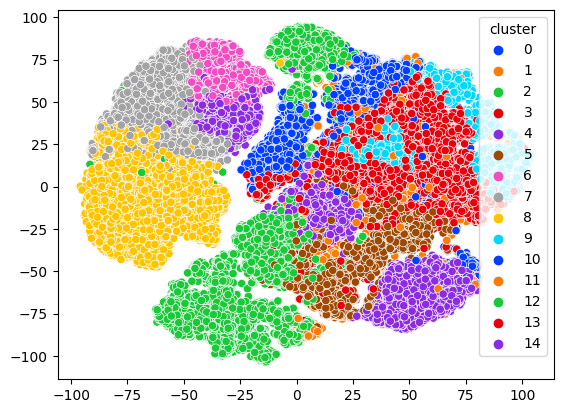

In [54]:
import seaborn as sns
predictions=predict_clusters(gmm,x_train_pca)
#print(predictions[:10])
df['cluster']=predictions
#fig,ax2=plt.subplots(ncols=2,figsize=(10,5))

sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue='cluster',data=df,palette='bright')
#ax2.set_xlabel('PCA component 1')
#ax2.set_xlabel('PCA component 2')
#ax2.set_title('Using PCA for Visualization')

In [55]:
#def sample_gen():
n_samples_per_cluster = 10
generated_samples = np.zeros((n_clusters*n_samples_per_cluster, x_train_pca.shape[1]))
for k in range(n_clusters):
  # Sample from the Gaussian distribution of cluster k
  samples_k = np.random.multivariate_normal(means[k], covariances[k], size=n_samples_per_cluster)
  generated_samples[k*n_samples_per_cluster:(k+1)*n_samples_per_cluster] = samples_k


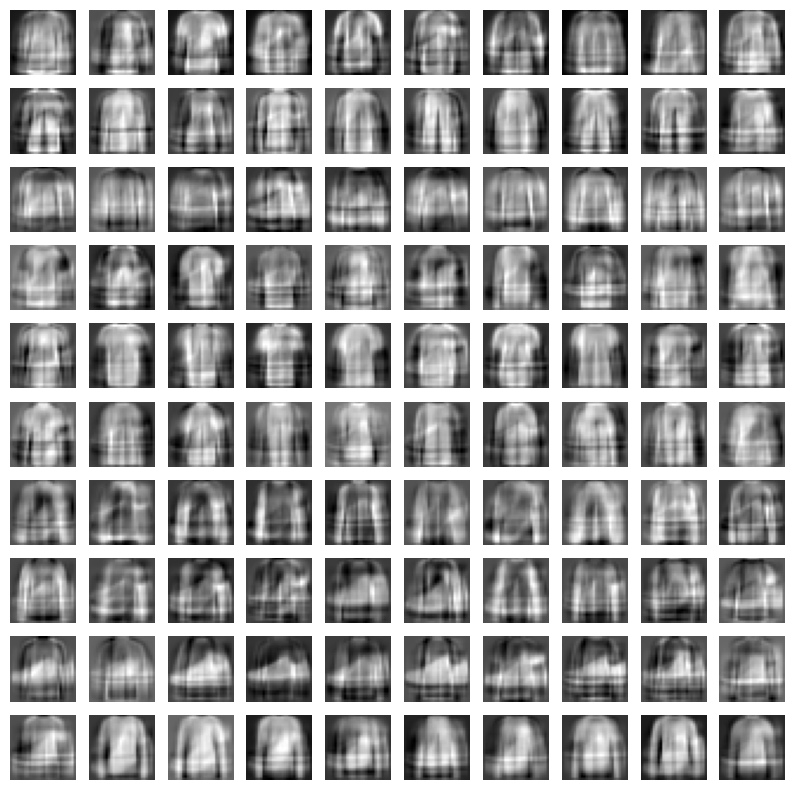

In [53]:
# Generate 100 samples from the GMM
n_samples = 100
#samples = generate_samples(means, covariances, weights, n_samples)
samples=pca.inverse_transform(generated_samples)
# Plot the samples in a 10x10 grid
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()
